# Problem Set 4

In this assignment, we will explore countmin sketches and bloom filters. We will use two text files `great-gatsby-fitzgerald.txt` and `war-and-peace-tolstoy.txt` to load up the text of two famous novels courtesy of Project Guttenberg. 

We will explore two tasks:
  - Counting the frequency of words of length 5 or more in both novels using a count-min sketch 
  - Using a bloom filter to approximately count how many words in the War and Peace novel already appears in the Great Gatsby.

## Step 1:  Making a Universal Hash Family (Already Done For You)

We will use a family of hash function that first starts by (a) generating a random prime number $p$ (we will use the Miller-Rabin primality test for this purpose); (b) generating random numbers a, b between 2 and p-1.

The hash function $h_{a,b,p} (n) = (an + b) \mod p$. 

Note that this function will be between 0 and p-1. We will need to also make sure to take the hash value modulo $m$ where $m$ is the size of the hashtable.

To hash strings, we will first use python's inbuilt hash function and then use $h_{a,b,p}$ on the result.

As a first step, we will generate a random prime number.

### (A) Generate Random Prime Numbers

In [1]:
# Python3 program Miller-Rabin randomized primality test
# Copied from geeksforgeeks: https://www.geeksforgeeks.org/primality-test-set-3-miller-rabin/
import random 

# Utility function to do 
# modular exponentiation. 
# It returns (x^y) % p 
def power(x, y, p): 
	
	# Initialize result 
	res = 1; 
	
	# Update x if it is more than or 
	# equal to p 
	x = x % p; 
	while (y > 0): 
		
		# If y is odd, multiply 
		# x with result 
		if (y & 1): 
			res = (res * x) % p; 

		# y must be even now 
		y = y>>1; # y = y/2 
		x = (x * x) % p; 
	
	return res; 

# This function is called 
# for all k trials. It returns 
# false if n is composite and 
# returns false if n is 
# probably prime. d is an odd 
# number such that d*2<sup>r</sup> = n-1 
# for some r >= 1 
def millerTest(d, n): 
	
	# Pick a random number in [2..n-2] 
	# Corner cases make sure that n > 4 
	a = 2 + random.randint(1, n - 4); 

	# Compute a^d % n 
	x = power(a, d, n); 

	if (x == 1 or x == n - 1): 
		return True; 

	# Keep squaring x while one 
	# of the following doesn't 
	# happen 
	# (i) d does not reach n-1 
	# (ii) (x^2) % n is not 1 
	# (iii) (x^2) % n is not n-1 
	while (d != n - 1): 
		x = (x * x) % n; 
		d *= 2; 

		if (x == 1): 
			return False; 
		if (x == n - 1): 
			return True; 

	# Return composite 
	return False; 

# It returns false if n is 
# composite and returns true if n 
# is probably prime. k is an 
# input parameter that determines 
# accuracy level. Higher value of 
# k indicates more accuracy. 
def isPrime( n, k): 
	
	# Corner cases 
	if (n <= 1 or n == 4): 
		return False; 
	if (n <= 3): 
		return True; 

	# Find r such that n = 
	# 2^d * r + 1 for some r >= 1 
	d = n - 1; 
	while (d % 2 == 0): 
		d //= 2; 

	# Iterate given number of 'k' times 
	for i in range(k): 
		if (millerTest(d, n) == False): 
			return False; 

	return True; 

# Driver Code 
# Number of iterations 
k = 4; 

print("All primes smaller than 100: "); 
for n in range(1,100): 
	if (isPrime(n, k)): 
		print(n , end=" "); 

# This code is contributed by mits (see citation above)


All primes smaller than 100: 
2 3 5 7 11 13 17 19 23 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 

### Step 2: Universal Hash Families

We will provide three useful functions for you:

  - `get_random_hash_function`: Generate triple of numbers `(p, a, b)` at random, where p is  prime, a and b are numbers between 2 and p-1. The hash function $h_{p,a,b}(n)$ is given by $ (an + b) \mod p$.
  
  - `hashfun`: apply the random hash function on a number `num`.
  - `hash_string`: apply the hash function on a string `hstr`. Note that the result is between 0 and p-1. If your hash table has size `m`, you should take a `mod m` on this result where you call `hash_string`.
  
  Please use these functions in your code below.

In [2]:
# Get a random triple (p, a, b) where p is prime and a,b are numbers between 2 and p-1
def get_random_hash_function():
    n = random.getrandbits(64)
    if n < 0: 
        n = -n 
    if n % 2 == 0:
        n = n + 1
    while not isPrime(n, 20):
        n = n + 1
    a = random.randint(2, n-1)
    b = random.randint(2, n-1)
    return (n, a, b)

# hash function fora number
def hashfun(hfun_rep, num):
    (p, a, b) = hfun_rep
    return (a * num + b) % p

# hash function for a string.
def hash_string(hfun_rep, hstr):
    n = hash(hstr)
    return hashfun(hfun_rep, n)    

## Step 3: Loading Data

We are going to load two files `great-gatsby-fitzgerald.txt` and `war-and-peace-tolstoy.txt` to load up the text of two famous novels courtesy of Project Guttenberg. We will filter all words of length >= 5 and also count the frequency of each word in a dictionary. This will be fast because it is going to use highly optimized hashtable (dictionaries) built into python.

In [3]:
# Let us load the "Great Gatsby" novel and extract all words of length 5 or more
filename = 'great-gatsby-fitzgerald.txt'
file = open (filename,'r')
txt = file.read()
txt = txt.replace('\n',' ')
words= txt.split(' ')
longer_words_gg = list(filter(lambda s: len(s) >= 5, words))
print(len(longer_words_gg))
# Let us count the precise word frequencies
word_freq_gg = {}
for elt in longer_words_gg:
    if elt in word_freq_gg:
        word_freq_gg[elt] += 1
    else:
        word_freq_gg[elt] = 1
print(len(word_freq_gg))

21342
8849


In [4]:
# Let us load the "War and Peace" novel by Tolstoy translation and extract all words of length 5 or more
filename = 'war-and-peace-tolstoy.txt'
file = open (filename,'r')
txt = file.read()
txt = txt.replace('\n',' ')
words= txt.split(' ')
longer_words_wp = list(filter(lambda s: len(s) >= 5, words))
print(len(longer_words_wp))
word_freq_wp = {}
for elt in longer_words_wp:
    if elt in word_freq_wp:
        word_freq_wp[elt] += 1
    else:
        word_freq_wp[elt] = 1
print(len(word_freq_wp))

237611
38777


## Problem 1: Implement count-min sketch

Implement `CountMinSketch` class below where `num_counters` is the number of counters.  You are given the constructor that already generates a random representative of a hash function family. Implement the functions:
  - `increment`
  - `approximateCount`.
  
Please read the constructor carefully: it initializes the counters and generates the hash function for you.
Also, when you call `hash_string` function defined previously, do not forget to take result modulo m.

In [5]:
# Class for implementing a count min sketch "single bank" of counters
class CountMinSketch:
    # Initialize with `num_counters`
    def __init__ (self, num_counters):
        self.m = num_counters
        self.hash_fun_rep = get_random_hash_function()
        self.counters = [0]*self.m

    # function: increment 
    # given a word, increment its count in the countmin sketch
    def increment(self, word):
        # my code here
        # Generate hash value for the word
        num = hash_string(self.hash_fun_rep, word)
        for i in range(len(self.hash_fun_rep)):
            # Map the hash value to a counter index
            h = (num + i) % self.m
            self.counters[h] += 1

    # function: approximateCount
    # Given a word, get its approximate count
    def approximateCount(self, word):
        # my code here
        # Generate hash value for the word
        num = hash_string(self.hash_fun_rep, word)
        min_count = float('inf')
        for i in range(len(self.hash_fun_rep)):
            # Map the hash value to a counter index
            h = (num + i) % self.m
            min_count = min(min_count, self.counters[h])
        return min_count

# We will now implement the algorithm for a bank of k counters

# Initialize k different counters
def initialize_k_counters(k, m): 
    return [CountMinSketch(m) for i in range(k)]

# Function increment_counters
# increment each of the individual counters with the word
def increment_counters(count_min_sketches, word):
    # my code here
    for cms in count_min_sketches:
        cms.increment(word)

# Function: approximate_count
# Get the approximate count by querying each counter bank and taking the minimum
def approximate_count(count_min_sketches, word):
    return min([cms.approximateCount(word) for cms in count_min_sketches])

Passed all tests: 10 points


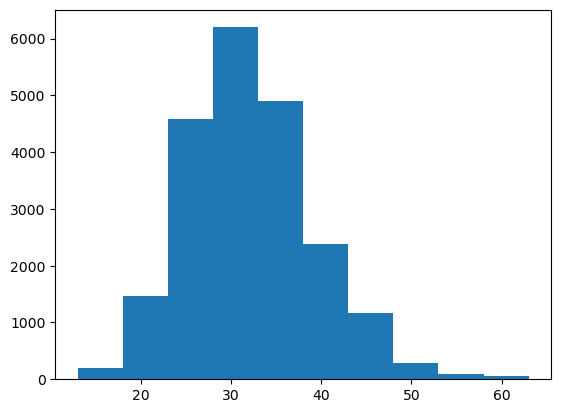

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt 

# Let's see how well your solution performs for the Great Gatsby words
cms_list = initialize_k_counters(5, 1000)
for word in longer_words_gg:
    increment_counters(cms_list, word)

discrepancies = []
for word in longer_words_gg:
    l = approximate_count(cms_list, word)
    r = word_freq_gg[word]
    assert ( l >= r)
    discrepancies.append( l-r )
    
plt.hist(discrepancies)

assert(max(discrepancies) <= 200), 'The largest discrepancy must be definitely less than 200 with high probability. Please check your implementation'
print('Passed all tests: 10 points')

Passed all tests: 5 points


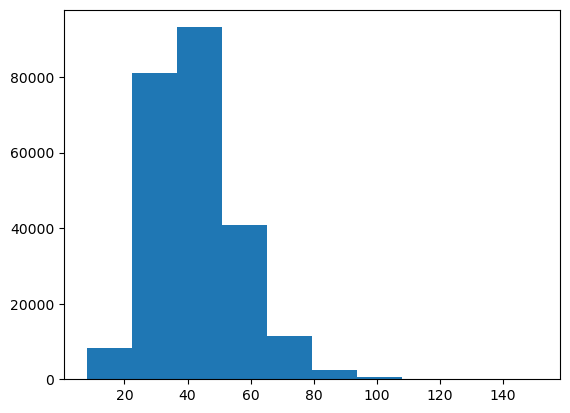

In [7]:
# Let's see how well your solution performs for the War and Peace
cms_list = initialize_k_counters(5, 5000)
for word in longer_words_wp:
    increment_counters(cms_list, word)

discrepancies = []
for word in longer_words_wp:
    l = approximate_count(cms_list, word)
    r = word_freq_wp[word]
    assert ( l >= r)
    discrepancies.append( l-r )

plt.hist(discrepancies)
print('Passed all tests: 5 points')

### Problem 1B

Check the data obtained above with calculations along the lines of what was done in class. If we had
$5$ banks of counters  with $5000$ counters each and a uniform hash function family, what is the probability that when counting a total of $N = 2.5\times 10^{5}$ words, we have a discrepancy by 80 or more.

This problem will not be graded but simply for you to understand the calculations involved.

YOUR ANSWER HERE

## Problem 2: Using a Bloom Filter to Count Common Words.

In this problem, we will implement a Bloom filter to count how many elements of `longer_words_wp` (the words of length 5 or more in War and Peace) appear in the Great-Gatsby novel.  To do so, we will do the following:
 - Instantiate a Bloom filter with number of bits `n` and number of hash functions `k`.
 - Insert all words from great-gatsby into the filter.
 - For each word from war and peace, check membership in the Bloom filter and count the number of yes answers.

In [8]:
class BloomFilter:
    def __init__(self, nbits, nhash):
        self.bits = [False]*nbits # Initialize all bits to fals
        self.m = nbits
        self.k = nhash
        # get k random hash functions
        self.hash_fun_reps = [get_random_hash_function() for i in range(self.k)]
    
    # Function to insert a word in a Bloom filter.
    def insert(self, word):
        # your code here
        for hfun_rep in self.hash_fun_reps:
            # Compute the hash for the word
            hash_value = hash_string(hfun_rep, word)
            # Map hash value to bit index
            index = hash_value % self.m
            # Set the bit to True
            self.bits[index] = True
        
    # Check if a word belongs to the Bloom Filter
    def member(self, word):
        # your code here
        for hfun_rep in self.hash_fun_reps:
            # Compute the hash for the word
            hash_value = hash_string(hfun_rep, word)
            # Map hash value to bit index
            index = hash_value % self.m
            # Check if the bit is set to True
            if not self.bits[index]:
                return False
        return True

In [9]:
#do the exact count
# it is a measure of how optimized python data structures are under the hood that
# this operation finishes very quickly.
all_words_gg = set(longer_words_gg)
exact_common_wc = 0
for word in longer_words_wp:
    if word in all_words_gg:
        exact_common_wc = exact_common_wc + 1
print(f'Exact common word count = {exact_common_wc}')

Exact common word count = 124595


In [10]:
# Try to use the same using a bloom filter.
bf = BloomFilter(100000, 5)
for word in longer_words_gg:
    bf.insert(word)
    
for word in longer_words_gg:
    assert (bf.member(word)), f'Word: {word} should be a member'

common_word_count = 0
for word in longer_words_wp:
    if bf.member(word):
        common_word_count= common_word_count + 1
print(f'Number of common words of length >= 5 equals : {common_word_count}')
assert ( common_word_count >= exact_common_wc)
print('All Tests Passed: 10 points')

Number of common words of length >= 5 equals : 124975
All Tests Passed: 10 points


## Problem 2 B

Given a Bloom filter with $m = 100000$ bits and $k = 5$ hash functions that  map each key uniformly at random to one of the bits (assumption), estimate the probability that $k$ bits $i_1, \ldots, i_k$ are simultaneously set when $n = 10000$ words are inserted. Assume that whether or not a particular bit is set is independent of another.

YOUR ANSWER HERE

## Manually Graded Solutions

### Problem 1 B 


Note that for each word we have $\mathbb{E}( \text{approxCount}(word) - \text{count}(word)) \leq \frac{N}{m}$.
The probability that for some word, the approximate count differs from the real one by at least $80$ for one of the counter banks is bounded by Markov Inequality as:  
$$ \mathbb{P}( \text{approxCount}(word) - \text{count}(word) \geq 80) \leq \frac{\mathbb{E}(\text{approxCount}(word) - \text{count}(word))}{80} \leq \frac{2.5\times 10^5}{80 \times 5000} \approx \frac{5}{8} $$

The probability that this happens for all five counter banks is bounded by $\left(\frac{5}{8}\right)^5 \approx 0.095$


However, this bound happens to be not so tight. Empirically, we see that this happens for roughly one word out of the nearly quarter million words in the corpus.

### Problem 2 B

The probability that any given bit is not set when $n$ words are inserted is 
$(1 - \frac{1}{m})^{kn} = (1 - \frac{1}{100000})^{5\times 10000} = e^{-0.5}$

The probability that all five bits are simultaneously set is $(1-e^{-0.5})^5 = 0.009$

Therefore, we will expect the false positive rate to be roughly $1\%$


## That's All Folks!